<a href="https://colab.research.google.com/github/IFuentesSR/SAMSARA_UAI/blob/main/PELT_deforestation_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize(project='xxx') #need initialize credentials

In [2]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.2 MB/s eta 0:00:00


In [12]:
# Folium setup.
import ruptures as rpt
import folium
import sys
import math
import re
import numpy as np
import pandas as pd
import time
from multiprocessing import Pool
import itertools
import datetime
import matplotlib.pyplot as plt
from scipy import interpolate, stats
import plotly.express as px
from collections import Counter
import scipy.ndimage as ndimage
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score



print(folium.__version__)

0.14.0


In [4]:
def mask(img):
    qua = ee.Image(img).select('QA_PIXEL')
    props = img.propertyNames()
    fill = qua.bitwiseAnd(1).eq(0)
    dilated = qua.bitwiseAnd(2).eq(0)
    cirrus = qua.bitwiseAnd(4).eq(0)
    clouds = qua.bitwiseAnd(8).eq(0)
    shadows = qua.bitwiseAnd(16).eq(0)
    snow = qua.bitwiseAnd(32).eq(0)
    return img.updateMask(dilated).updateMask(cirrus).updateMask(clouds).updateMask(shadows).updateMask(snow).updateMask(fill).multiply(0.0000275).add(-0.2).copyProperties(img, props)


def ndvil8(img):
    props = img.propertyNames()
    ix = img.normalizedDifference(['SR_B5', 'SR_B4'])
    ix = ix.updateMask(ix.gt(0))
    return img.addBands(ix.rename('ndvi')).copyProperties(img, props)


def ndvil57(img):
    props = img.propertyNames()
    ix = img.normalizedDifference(['SR_B4', 'SR_B3'])
    ix = ix.updateMask(ix.gt(0))
    return img.addBands(ix.rename('ndvi')).copyProperties(img, props)


def get_date(x):
    return ee.Date(x).format('YYYY-MM-dd')


def mosaicking(collection):
    def inner(date):
        coll = collection.select('ndvi').filterDate(ee.Date(date), ee.Date(date).advance(1, 'day'))
        img = ee.Image(coll.first())
        props = img.propertyNames()
        return ee.Image(-99.).where(coll.mosaic().gte(-1), coll.mosaic())
    return inner


def getting_mean(collection):
    def inner(date):
        coll = collection.filterDate(ee.Date(date), ee.Date(date).advance(1, 'day'))
        img = coll.first()
        # props = img.propertyNames()
        # return img.copyProperties(coll.first(), props)
        return img
    return inner


def set_id(fea):
    return fea.set('id', fea.id())


def to_year(img):
    year2000 = 730485
    year = img.subtract(year2000).divide(365)
    return ee.Image(2000).add(ee.Image(year))


def resample(target):
    def inner(img):
        return img.reproject(ee.Image(target).select('ndvi').projection())
    return inner


def sample(geo):
    def inner(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        ndvi = img.reduceRegion('mean', geo.geometry(), scale=30).values().get(0)
        return ee.Feature(None, {'date':date, 'ndvi':ndvi})
    return inner


def sampleS2(geo):
    def inner(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        ndvi = img.reduceRegion('mean', geo.geometry(), scale=10).values().get(0)
        return ee.Feature(None, {'date':date, 'ndvi':ndvi})
    return inner

In [14]:
import datetime


def get_days(df):
    '''converts breaks to days from 2016-01-01'''
    return lambda x: (df.loc[x]['date'] - pd.to_datetime('2000-01-01')).days + 0.0 if x > 0 else np.nan


def bkps2dates(array, df_dates):
    df_array = pd.DataFrame(index=df_dates.date.values, data={'ndvi':array, 'ix':df_dates['ix'].values})
    df_array2 = df_array.dropna(how='any')
    model = 'rbf' #"l1", "l2", "rbf"
    algo = rpt.KernelCPD(kernel=model, min_size=3, jump=5).fit(df_array2['ndvi'].values)
    my_bkps = algo.predict(pen=40)
    if len(my_bkps) > 1:
        return df_array2.reset_index().iloc[my_bkps[-2]-1]['ix'], df_array2.reset_index().iloc[my_bkps[-2]-1]['index']
    else:
        return np.nan, pd.to_datetime('1900-01-01')


def bkps2dates2(array, df_dates, pen):
    df_array = pd.DataFrame(index=df_dates.date.values, data={'ndvi':array, 'ix':df_dates['ix'].values})
    df_array2 = df_array.dropna(how='any')
    model = 'rbf' #"l1", "l2", "rbf"
    algo = rpt.KernelCPD(kernel=model, min_size=3, jump=5).fit(df_array2['ndvi'].values)
    my_bkps = algo.predict(pen=pen)
    my_bkps = my_bkps[:-1]
    my_bkps = [n-1 for n in my_bkps]
    df3 = df_array2.reset_index()
    df3 = df3[df3['index'] > '2016-01-01']
    my_bkps = list(set(my_bkps).intersection(df3.index.tolist()))
    if len(df3.loc[my_bkps]) >= 1:
        days = [(df3.loc[n]['index'] - pd.to_datetime('1900-01-01')).days for n in my_bkps]
        arr = np.full((5,1),np.nan)
        arr[:len(days)] = np.array(days).reshape(-1, 1)
        bks = [df3.loc[n]['ix'] for n in my_bkps]# if (n.index - pd.to_datetime('1900-01-01')).days > 42368]
        a = np.full((5, 1), np.nan)
        a[:len(bks)] = np.array(bks).reshape(-1, 1)
        return a, arr
    else:
        return np.full((5, 1), np.nan), np.full((5, 1), np.nan)


def masking_breaks(dates_df, breaks, dates, threshold):
    date_bks = np.sort(list(set(np.sort([(dates_df.set_index('ix').loc[n]['date'] - pd.to_datetime('1900-01-01')).days for n in np.sort(np.unique(breaks)[:-1])]))))
    mask_bks = [(((dates >= n - 30) & (dates <= n))).astype(int).max(axis=0) for n in date_bks]
    date_changes = [np.max((dates == n).astype(int) * n, axis=0) for n in date_bks]
    cumm_msk = [ndimage.convolve(n, np.ones((50,50)), mode='constant') * n for n in mask_bks]
    masked_dates = [n * (cumm_msk[i] < threshold).astype(int) for i, n in enumerate(date_changes)]
    return masked_dates

In [5]:
forested = ee.FeatureCollection('users/ignaciofuentessanroman/IWF_forests').map(set_id)
deforested = ee.FeatureCollection('users/ignaciofuentessanroman/IWF_deforestation').map(set_id)

ids_forested = forested.aggregate_array('id').distinct().getInfo()
ids_deforested = deforested.aggregate_array('id').distinct().getInfo()

In [7]:
fea = deforested.filter(ee.Filter.eq('id', '00000000000000000012')).first()

l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(fea.geometry()).map(mask).map(ndvil8)
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(fea.geometry()).map(mask).map(ndvil8)

In [8]:
geo = ee.Feature(fea)
id = geo.getMapId()
l8_2016 = l8.filterDate('2016-01-01', '2017-01-01').mean().getMapId({'bands':['SR_B5', 'SR_B4', 'SR_B3'], 'min': 0, 'max': 0.3})
l8_2021 = l9.filterDate('2021-01-01', '2022-01-01').mean().getMapId({'bands':['SR_B5', 'SR_B4', 'SR_B3'], 'min': 0, 'max': 0.3})
centroid = geo.centroid().getInfo()['geometry']['coordinates'][::-1]
map = folium.Map(location=centroid, zoom_start=16)
folium.TileLayer(
    tiles=l8_2016['tile_fetcher'].url_format,
    attr='Map Data © Google Earth Engine',
    overlay=True,
    name='s2_2018',
  ).add_to(map)
folium.TileLayer(
    tiles=l8_2021['tile_fetcher'].url_format,
    attr='Map Data © Google Earth Engine',
    overlay=True,
    name='s2_2021',
  ).add_to(map)
folium.TileLayer(
    tiles=id['tile_fetcher'].url_format,
    attr='Map Data © Google Earth Engine',
    overlay=True,
    name='feature',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [9]:
paths = l8.aggregate_histogram('WRS_PATH').getInfo()
path = [i for i in paths if paths[i]==sorted(paths.values())[-1]][0]
l8 = l8.filter(ee.Filter.eq('WRS_PATH', float(path)))
l9 = l9.filter(ee.Filter.eq('WRS_PATH', float(path)))
l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(fea.geometry()).filterDate('2000-01-01', '2023-01-01').filter(ee.Filter.eq('WRS_PATH', float(path))).map(mask).map(ndvil57)
l5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(fea.geometry()).filterDate('2000-01-01', '2023-01-01').filter(ee.Filter.eq('WRS_PATH', float(path))).map(mask).map(ndvil57)

landsat = l9.merge(l8).merge(l7).merge(l5).select('ndvi').sort('system:time_start').filterDate('2000-01-01', '2022-06-01')

In [61]:
data = landsat.map(sample(fea)).getInfo()
dates = [pd.to_datetime(n['properties']['date']) for n in data['features']]
ndvi = [n['properties']['ndvi'] if 'ndvi' in n['properties'] else None for n in data['features']]
df = pd.DataFrame(index=dates, data={'ndvi':ndvi, 'date':dates, 'ix':range(len(ndvi))})
df = df.dropna(how='any')

In [60]:
my_bkps = bkps2dates2(df['ndvi'], df, 30)

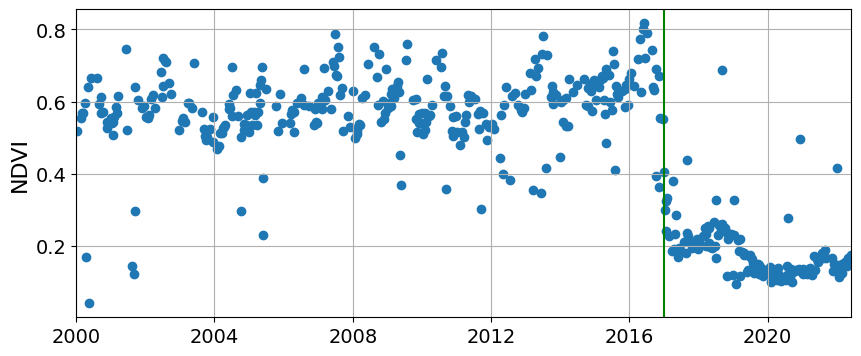

In [59]:
fig = plt.figure(figsize=(10,4))
plt.scatter(dates, ndvi)
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2022-06-01'))
for n in my_bkps[0]:
    if len(df.loc[df['ix'] == n[0]]['date'].values) > 0:
        plt.axvline(x=df.loc[df['ix'] == n[0]]['date'].values[0], color='g')

plt.grid()
plt.ylabel('NDVI', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [70]:
stack = landsat.toBands().toFloat().sampleRectangle(fea.geometry().bounds().buffer(300), defaultValue=-99.).getInfo()
imgs = [n for n in stack['properties']]
dates_imgs = [pd.to_datetime(re.findall('\d{8}', n)[0], format='%Y%m%d') for n in imgs]
df_dates = pd.DataFrame(data={'date':dates_imgs, 'ix':range(len(dates_imgs))})
df_dates = df_dates.sort_values('date')
ix_anom = df_dates.reset_index()[df_dates.reset_index()['date'] > '2016-01-01'].index[0]
reorder_ix = df_dates['ix'].values
reorder_imgs = [imgs[n] for n in reorder_ix]
stacked = np.stack([stack['properties'][n] for n in reorder_imgs])
stacked[stacked < 0] = np.nan
bks, dates = np.apply_along_axis(bkps2dates2, 0, stacked, df_dates, 30)
bks = bks.reshape(5, stacked.shape[1], stacked.shape[2])
dates = dates.reshape(5, stacked.shape[1], stacked.shape[2])

In [82]:
values = np.unique((dates/365 + 1900)[0,:,:])[:-1]
values = np.linspace(np.min(values), np.max(values), 4)
coords = np.array(fea.geometry().bounds().buffer(300).coordinates().getInfo())[0, :, :]
longs = coords[:, 0]
lats = coords[:, 1]

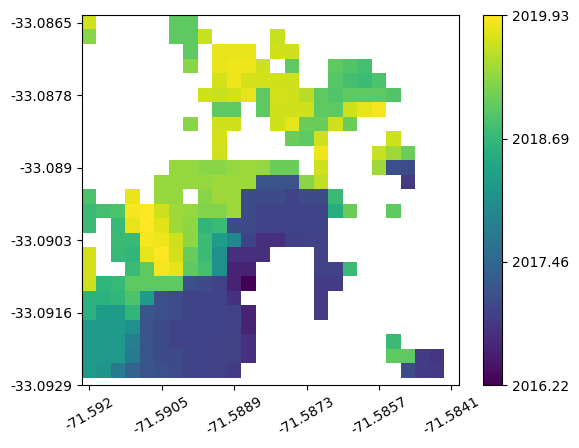

In [85]:
fig, ax = plt.subplots()
f1 = ax.imshow((dates/365 + 1900)[0,:,:],
               vmin=np.nanmin((dates/365 + 1900)[0,:,:]),
               vmax=np.nanmax((dates/365 + 1900)[0,:,:]))
cb = fig.colorbar(f1, ticks=values)
cb.ax.set_yticklabels([round(n, 2) for n in values])
plt.xticks([0, 5, 10, 15, 20, 25], labels=np.round(np.linspace(np.min(longs), np.max(longs), 6), 4))
plt.yticks([0, 5, 10, 15, 20, 25], labels=np.round(np.linspace(np.max(lats), np.min(lats), 6), 4))
plt.tick_params(axis='x', rotation=30)
plt.show()

##*ToDo*
Implement break magnitudes